In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

from pathlib import Path
from tqdm.auto import tqdm

In [2]:
import sys
sys.path.append('..')

In [3]:
from lib.models import HMM, HMMFilter
from lib.policies import StaticRoutingPolicy, MinimalDelayRoutingPolicy
from lib.policies import StaticMonitoringPolicy, RecedingHorizonPolicy
from lib.simulator import Scenario, Simulator

In [4]:
# scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/2_paths/')
# scenarios_paths = [x for x in scenarios_dir.iterdir() if x.is_dir()]

In [5]:
olivier_scenarios = [
    '2_paths/Paris_Tokyo',
#     '2_paths/Singapore_Moscow',
    '3_paths/Singapore_HongKong',
    '4_paths/Haifa_Santiago',
    '4_paths/Paris_Santiago'
]


scenarios_dir = Path('../dataset/NLNOG/scenarios_v2/')
scenarios_paths = [scenarios_dir.joinpath(x) for x in olivier_scenarios]

In [6]:
benchmarks = {}

# Progress bar
p = tqdm(scenarios_paths)
series_temp={}
for scenario_path in p:
    scenario = Scenario.from_path(scenario_path)
    series_temp[scenario.name]=scenario.timeseries
    benchmark = {'logs': {}}
    
    # Constant monitoring cost
    costs = np.ones(scenario.n_paths) * 0.5

    # (Routing Policy, Monitoring Policy)
    policies = []

    # IP Path
    policies.append((
        StaticRoutingPolicy(0),
        StaticMonitoringPolicy(np.zeros(scenario.n_paths))
    ))
    
    # Receding Horizon
    policies.append((
        MinimalDelayRoutingPolicy(),
        RecedingHorizonPolicy(scenario.models, costs, τ_max=100, ρ=0.99, H=1, one_route=False)
    ))

    for routing_policy, monitoring_policy in policies:
        policy_name = '{} / {}'.format(routing_policy, monitoring_policy)
        p.set_description('{} ({})'.format(scenario.name, policy_name))

        try:
            sim = Simulator(scenario.timeseries, scenario.models, costs)
            benchmark['logs'][policy_name] = sim.benchmark(monitoring_policy, routing_policy)
        except Exception as e:
            print('Failed to simulate {}'.format(policy_name))
            print(e)
    
    benchmarks[scenario.name] = benchmark

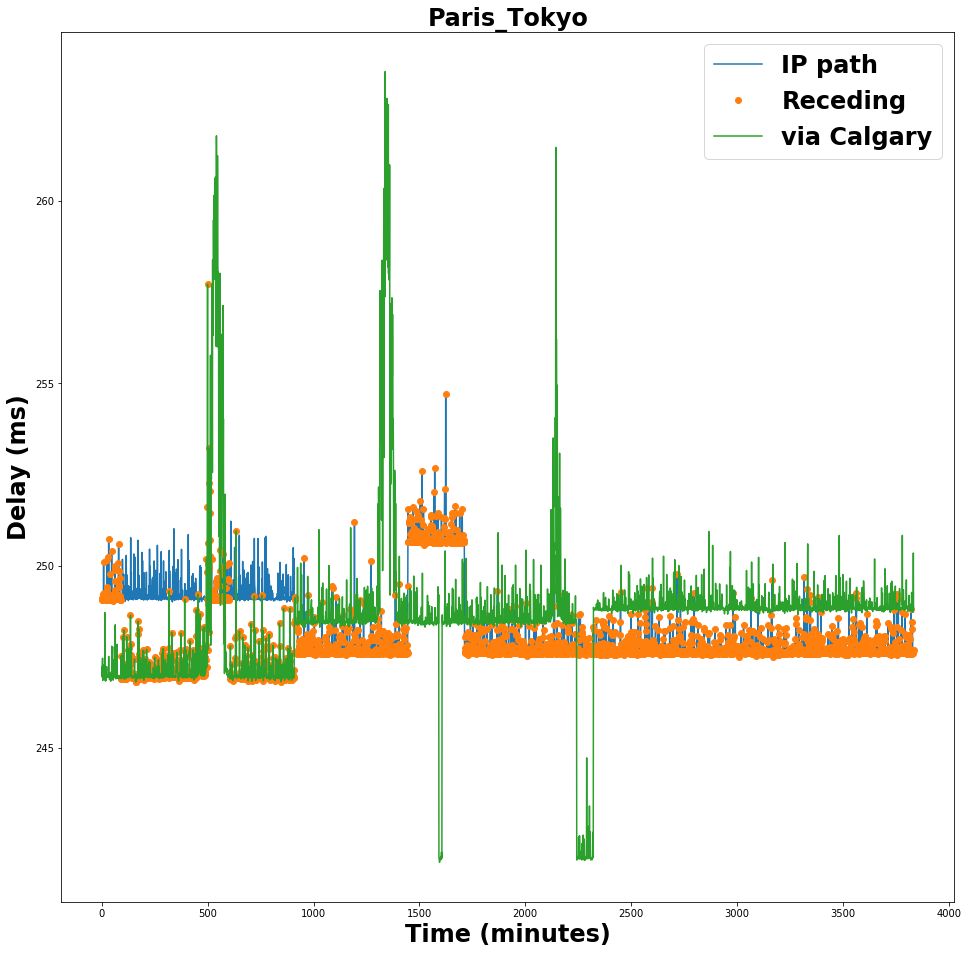

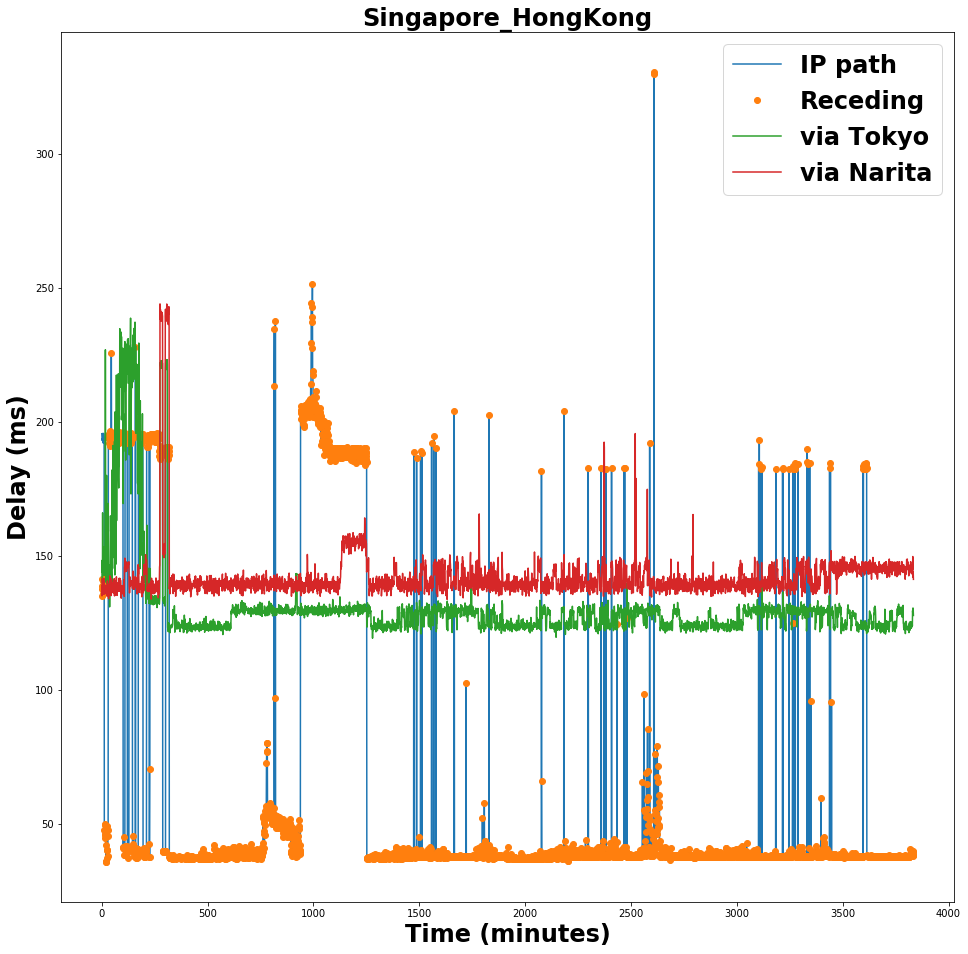

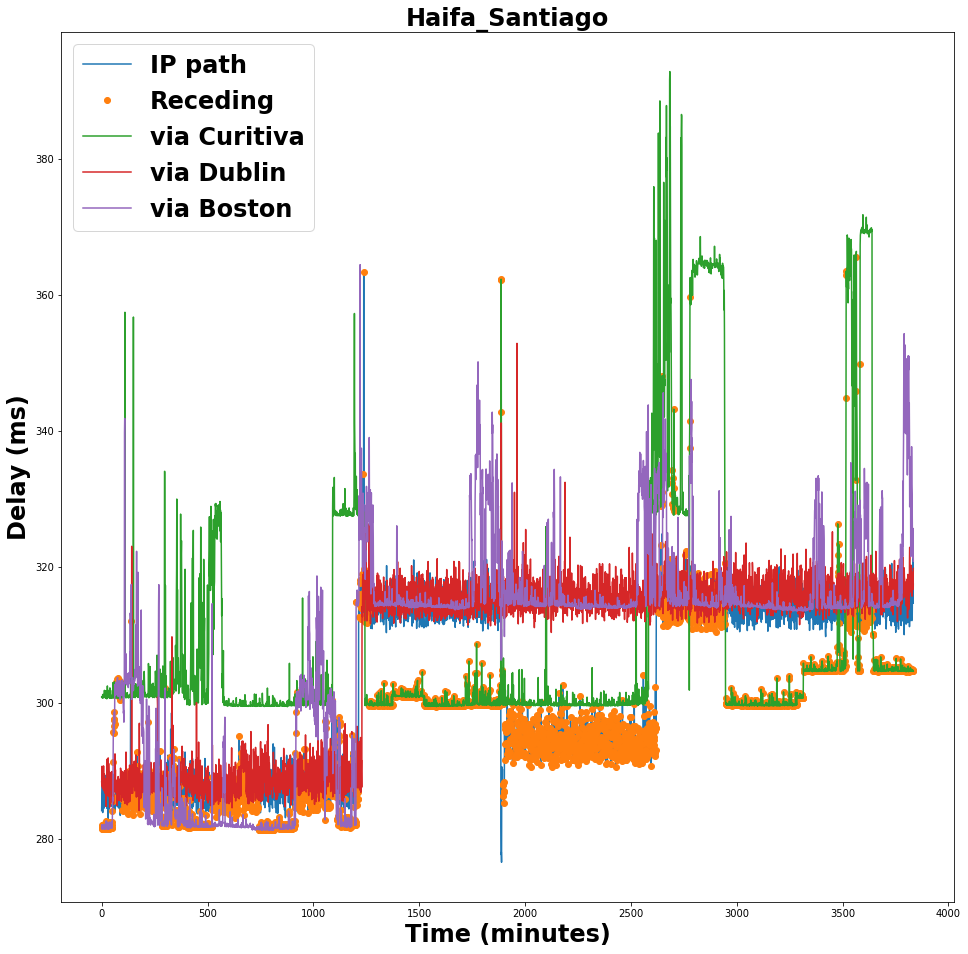

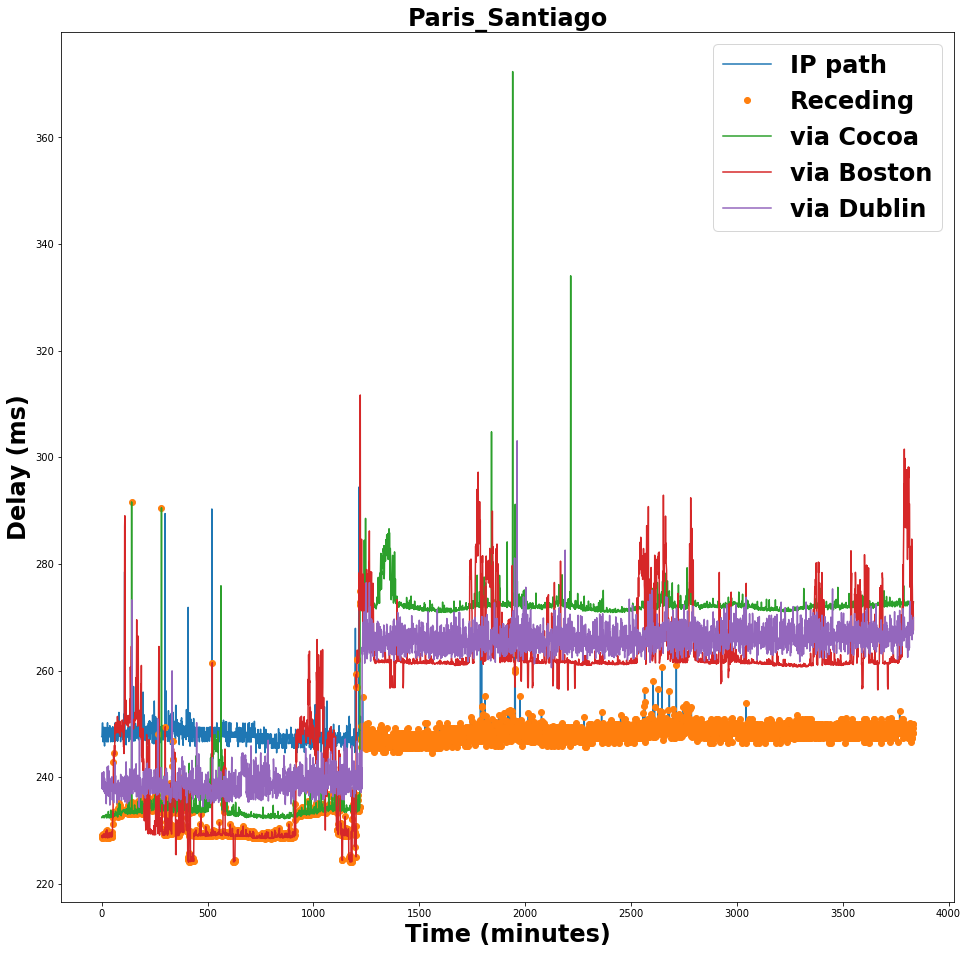

In [7]:
# print(scenario.models)
# print(sim.timeseries)
legend_properties = {'weight':'bold', 'size':'24'}
proxies={'Paris_Tokyo': ['IP path', 'via Calgary'], 'Singapore_Moscow': ['IP path', 'via Gibraltar'], 'Singapore_HongKong': ['IP path', 'via Tokyo', 'via Narita'], 'Haifa_Santiago': ['IP path', 'via Curitiva', 'via Dublin', 'via Boston'], 'Paris_Santiago': ['IP path', 'via Cocoa', 'via Boston', 'via Dublin']}
for scenario, benchmark in benchmarks.items():
#     print(scenario)
#     print(benchmark)
    fig=plt.figure(figsize=(16,16))
    ax=fig.add_subplot(1,1,1)
    for policy, log in benchmark['logs'].items():
#         print(policy)
#         print(log)
        if policy=='Static Route 0 / Never Measure':
            ax.plot(log.get('delay'), label='IP path')
        else:
            ax.plot(log.get('delay'), 'o', label='Receding')
    for paths in range(1, len(series_temp[scenario])):
        ax.plot(series_temp[scenario][paths], label=proxies[scenario][paths])
    ax.set_xlabel('Time (minutes)', fontsize=24, weight='bold')
    ax.set_ylabel('Delay (ms)', fontsize=24, weight='bold')
    ax.set_title(str(scenario), fontsize=24, weight='bold')
    plt.legend(prop=legend_properties)
    plt.savefig('Delay'+str(scenario)+'.pdf')
    plt.show()

In [8]:
# print(scenario.models)
# print(sim.timeseries)
for scenario, benchmark in benchmarks.items():
    print(scenario)
#     print(benchmark['logs'].items())
    for policy, log in benchmark['logs'].items():
        no_min=0
        delay=log.get('delay')
        minimo=delay
#         print(minimo)
        for i in range(len(delay)):
            menor=False
            for j in range(len(series_temp[scenario])):
                if delay[i]>series_temp[scenario][j][i]:
                    menor=True
                if minimo[i]>series_temp[scenario][j][i]:
                    minimo[i]=series_temp[scenario][j][i]
            if menor==True:
                no_min+=1
        print(policy, 1-no_min*1./len(delay), sum(minimo)*1./len(delay))

Paris_Tokyo
Static Route 0 / Never Measure 0.6810951760104302 247.5475204693608
Minimal Delay / RH(ρ=0.99,H=1) 0.8594524119947848 247.5475204693608
Singapore_HongKong
Static Route 0 / Never Measure 0.850586701434159 53.945273011734116
Minimal Delay / RH(ρ=0.99,H=1) 0.8534550195567144 53.945273011734116
Haifa_Santiago
Static Route 0 / Never Measure 0.3421121251629726 295.98711890482406
Minimal Delay / RH(ρ=0.99,H=1) 0.8099087353324641 295.98711890482406
Paris_Santiago
Static Route 0 / Never Measure 0.678748370273794 242.91095176010458
Minimal Delay / RH(ρ=0.99,H=1) 0.9619295958279009 242.91095176010458


In [9]:
def get_benchmark_df(benchmarks):
    records = []

    for scenario, benchmark in benchmarks.items():
        for policy, log in benchmark['logs'].items():
            records.append({
                'scenario': scenario,
                'policy': policy,
                'avg_delay': log.avg_delay(),
                'avg_cost': log.avg_cost(),
                'avg_processing_time': log.avg_processing_time() / 1e3,
                'avg_n_measures': log.avg_n_measures()
            })

    return pd.DataFrame.from_records(records)

In [10]:
get_benchmark_df(benchmarks)

,avg_cost,avg_delay,avg_n_measures,avg_processing_time,policy,scenario
0,0.000000,248.308882,0.000000,2.958396,Static Route 0 / Never Measure,Paris_Tokyo
1,0.002086,247.926225,0.004172,680.787276,"Minimal Delay / RH(ρ=0.99,H=1)",Paris_Tokyo
2,0.000000,63.244123,0.000000,3.685215,Static Route 0 / Never Measure,Singapore_HongKong
3,0.002477,63.069361,0.004954,1687.414813,"Minimal Delay / RH(ρ=0.99,H=1)",Singapore_HongKong
4,0.000000,301.964132,0.000000,3.299778,Static Route 0 / Never Measure,Haifa_Santiago
5,0.076402,297.192034,0.152803,2106.532635,"Minimal Delay / RH(ρ=0.99,H=1)",Haifa_Santiago
6,0.000000,248.410657,0.000000,2.558235,Static Route 0 / Never Measure,Paris_Santiago
7,0.047327,243.165283,0.094654,2636.259905,"Minimal Delay / RH(ρ=0.99,H=1)",Paris_Santiago


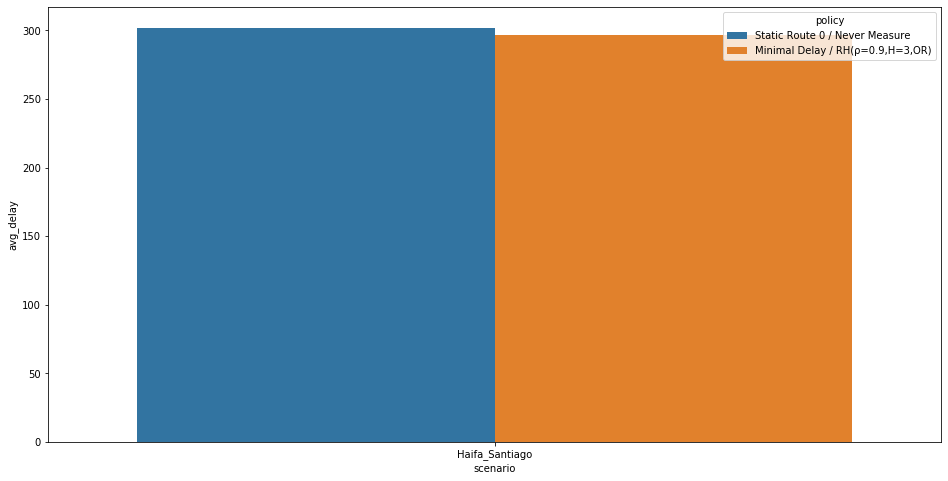

In [60]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_delay', hue='policy', data=df)
# plt.savefig('../figures/benchmark_delay_v2.png', bbox_inches='tight', dpi=300)

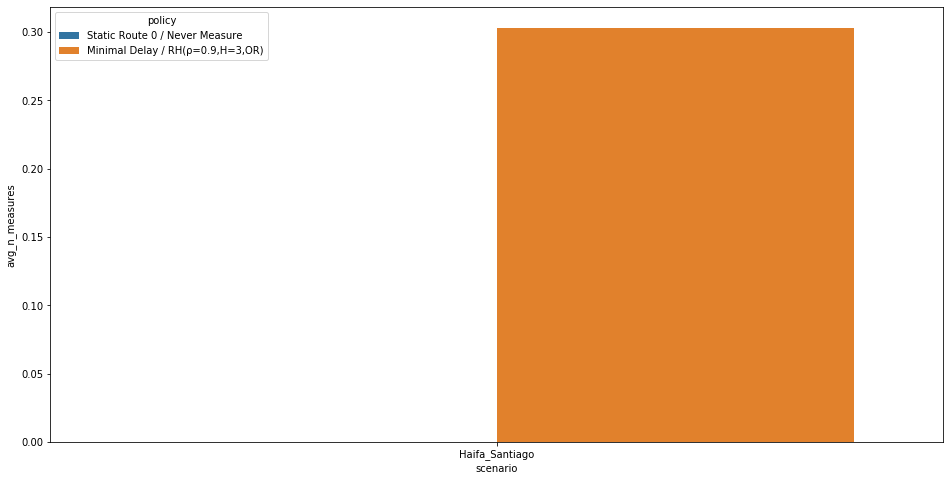

In [61]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_n_measures', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

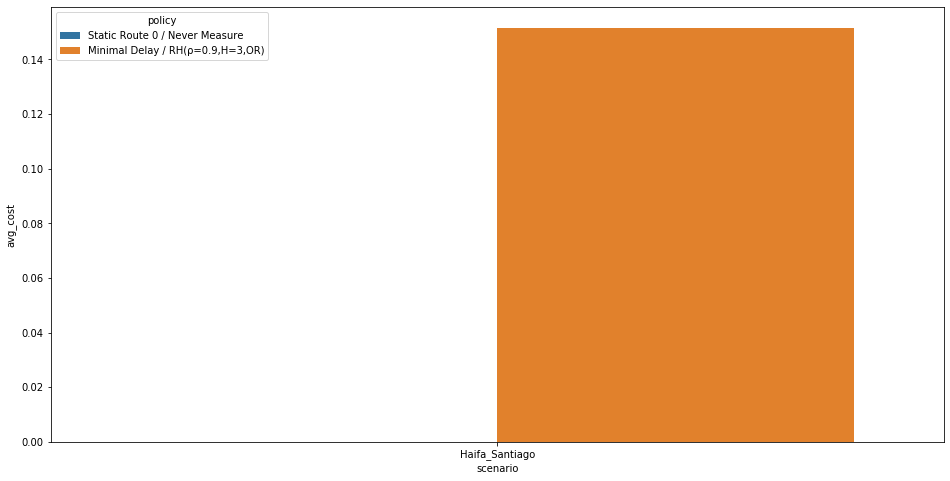

In [62]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_cost', hue='policy', data=df)
# plt.savefig('../figures/benchmark_cost_v2.png', bbox_inches='tight', dpi=300)

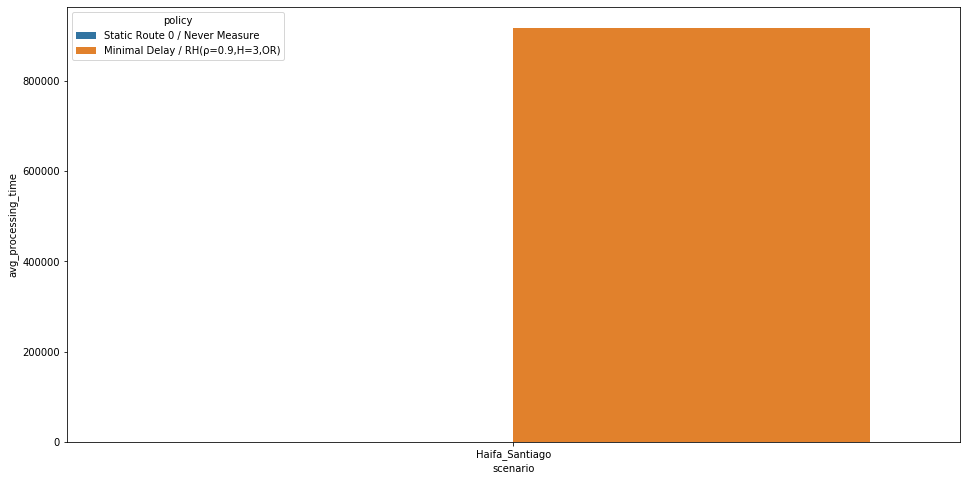

In [63]:
df = get_benchmark_df(benchmarks)
plt.figure(figsize=(16,8))
sns.barplot(x='scenario', y='avg_processing_time', hue='policy', data=df)
# plt.savefig('../figures/benchmark_acc_v2.png', bbox_inches='tight', dpi=300)